In [1]:
import sys
sys.path.append('../..')

import json

import torch
from torch.optim import SGD, Adam
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch.utils.tensorboard import SummaryWriter
from tools.gaia_dataset import SampleGaiaDataset
from tools.gnn_models import GCNEdgeBased
from tools.evaluation_metric import *
from tools.cluster_functions import *

In [2]:
writer = SummaryWriter()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

feature_columns = ['Etot', 'JR', 'Jz', 'Jphi', 'RGC', 'Vtot', 'U', 'V', 'W', 'vr', 'vphi', 'PhiGC', 'ZGC']
position_columns = ['XGC', 'YGC', 'ZGC']

2023-05-16 00:13:53.972557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 00:13:55.698019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-16 00:13:55.698247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-16 00:13:55.698255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
data_transforms = T.Compose(transforms=[T.KNNGraph(k=300, force_undirected=True), T.GDC(sparsification_kwargs={'avg_degree':300, 'method':'threshold'})]) #
gaia_dataset = SampleGaiaDataset('../../data/gaia', feature_columns, sample_size=2000, num_samples=20, pre_transform=data_transforms)
gaia_loader = DataLoader(gaia_dataset, batch_size=1, shuffle=True)

Processing...
Done!


In [5]:
model = GANOrigEdgeBased(len(feature_columns), regularizer=0).to(device)
model.load_state_dict(torch.load('../../train_script/weights/GANOrigEdgeBased_model300new/100.pth')['model_state_dict'])

<All keys matched successfully>

In [6]:
def evaluate(n_components, graph, model):
    graph = graph.to(device)
    with torch.no_grad():
        model.eval()
        edge_pred = model(graph)
    adj = torch.sparse_coo_tensor(graph.edge_index.cpu(), edge_pred.cpu(), (len(graph.x), len(graph.x))).to_dense()
    FX = C_Spectral(adj, n_components=n_components)
    return FX

In [17]:
graph = next(iter(gaia_loader))
FX = evaluate(50, graph, model)
clusters = [f'cluster {idx}' for idx in FX]

/home/michaelyhuang/venv/gaia/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/michaelyhuang/venv/gaia/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [18]:
import seaborn as sns

In [19]:
local_graph = graph.to('cpu')

<AxesSubplot: >

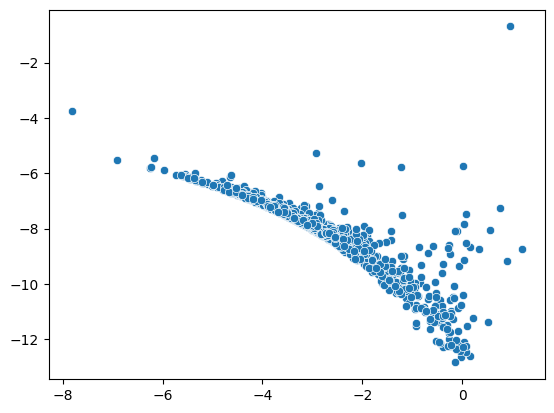

In [20]:
sns.scatterplot(x=local_graph.x[:,3], y=local_graph.x[:,0])

<AxesSubplot: >

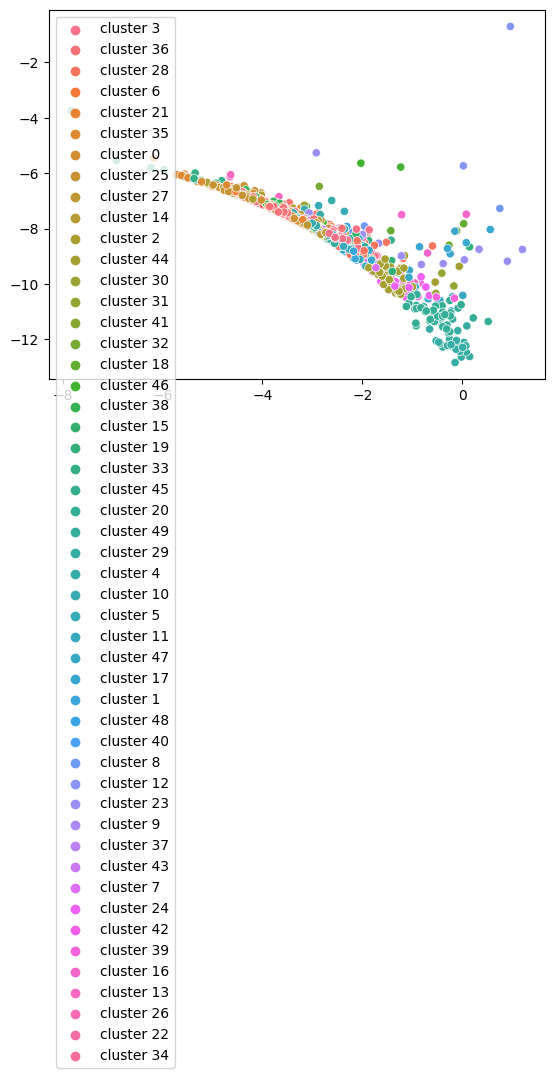

In [22]:
sns.scatterplot(x=local_graph.x[:,3], y=local_graph.x[:,0], hue=clusters)